In [1]:
import operator
from typing import Annotated, List, Literal, Sequence, TypedDict

import tiktoken
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.tools import DuckDuckGoSearchRun, TavilySearchResults
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import (ChatGoogleGenerativeAI,
                                    GoogleGenerativeAIEmbeddings)
from langchain_groq import ChatGroq
from langchain_ollama import OllamaLLM
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, Graph, MessagesState, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import tool

/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
load_dotenv()
llama = OllamaLLM(model="llama3.2")
gemini = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
groq_model = ChatGroq(model_name="gemma2-9b-it")
tavily_tool = TavilySearchResults()
duck_tool = DuckDuckGoSearchRun()

### 1. Langgraph with Structured Output

In [43]:
class ProductDetails(BaseModel):
    """Represents the product name, price and the processor of a tech product"""
    name: str = Field(..., description="Name of the product")
    processor: str = Field(..., description="Name of the processor used in the product")
    price: int = Field(..., description="Price of the product in Indian rupees")

class AgentState(MessagesState):
    product: ProductDetails

In [44]:
@tool
def crawl_web(query: str):
    """search in web to find the product name, processor used and the price of the product """
    print("\n===== Executing Tool =====\n")
    response = duck_tool.invoke(query)
    return response
tools = [crawl_web]
tool_node = ToolNode(tools=tools)


In [45]:
groq_with_tools = groq_model.bind_tools(tools=tools)
groq_with_structured_output = groq_model.with_structured_output(ProductDetails)

def call_model(state: AgentState):
    query = state["messages"]
    response = groq_with_tools.invoke(query)
    return {"messages": [response]}

def call_response(state: AgentState):
    print("\n===== Executing Response =====\n")
    query = state["messages"][-1].content
    response = groq_with_structured_output.invoke([HumanMessage(content=query)])
    print(response)
    return {"product_details": response}

In [49]:
def route_call(state: AgentState):
    message = state["messages"][-1]
    print(f"\nFrom Route {message}\n")
    if message.tool_calls:
        return "tools"
    return "response"

In [50]:
wf1 = StateGraph(AgentState)

wf1.add_node("model", call_model)
wf1.add_node("tools", tool_node)
wf1.add_node("respond", call_response)

wf1.set_entry_point("model")
wf1.add_conditional_edges("model", route_call, {"tools": "tools", "response": "respond"})
wf1.add_edge("tools", "model")
wf1.set_finish_point("respond")

app1 = wf1.compile()

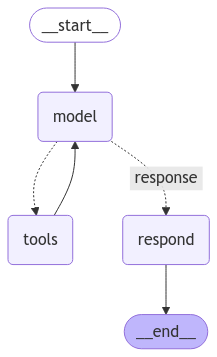

In [10]:
display(Image(app1.get_graph().draw_mermaid_png()))

In [51]:
app1.invoke({"messages": [("human",  "Details of Macbook Air M1")]})


From Route content='' additional_kwargs={'tool_calls': [{'id': 'call_sf5k', 'function': {'arguments': '{"query":"details of Macbook Air M1"}', 'name': 'crawl_web'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 956, 'total_tokens': 1043, 'completion_time': 0.158181818, 'prompt_time': 0.038909583, 'queue_time': 0.020387958000000005, 'total_time': 0.197091401}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-5c709125-876c-453c-bb30-efaf1543b711-0' tool_calls=[{'name': 'crawl_web', 'args': {'query': 'details of Macbook Air M1'}, 'id': 'call_sf5k', 'type': 'tool_call'}] usage_metadata={'input_tokens': 956, 'output_tokens': 87, 'total_tokens': 1043}


===== Executing Tool =====



/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(



From Route content='' additional_kwargs={'tool_calls': [{'id': 'call_dq9k', 'function': {'arguments': '{"query":"specifications of the MacBook Air model A2337"}', 'name': 'crawl_web'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 1420, 'total_tokens': 1476, 'completion_time': 0.101818182, 'prompt_time': 0.045789419, 'queue_time': 0.023055400000000004, 'total_time': 0.147607601}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-6ae24629-57f8-4955-93df-cd1f1579b728-0' tool_calls=[{'name': 'crawl_web', 'args': {'query': 'specifications of the MacBook Air model A2337'}, 'id': 'call_dq9k', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1420, 'output_tokens': 56, 'total_tokens': 1476}


===== Executing Tool =====



/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(



From Route content='The MacBook Air A2337 comes with the Apple M1 chip. It has 8 CPU cores and 7 or 8 GPU cores.  It comes with 8GB or 16GB of unified memory.  The storage is a 256GB, 512GB, 1TB, or 2TB SSD.  The display is a 13.3-inch Retina display with a resolution of 2560 x 1600 pixels. \n\n\n\n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 109, 'prompt_tokens': 1925, 'total_tokens': 2034, 'completion_time': 0.198181818, 'prompt_time': 0.061425313, 'queue_time': 0.023415674000000004, 'total_time': 0.259607131}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-6a6d2359-0f33-40ab-9290-318f20d226c2-0' usage_metadata={'input_tokens': 1925, 'output_tokens': 109, 'total_tokens': 2034}


===== Executing Response =====

name='MacBook Air A2337' processor='Apple M1' price=0


{'messages': [HumanMessage(content='Details of Macbook Air M1', additional_kwargs={}, response_metadata={}, id='a640e1da-9779-47d0-b000-58bd3ae278c5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sf5k', 'function': {'arguments': '{"query":"details of Macbook Air M1"}', 'name': 'crawl_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 956, 'total_tokens': 1043, 'completion_time': 0.158181818, 'prompt_time': 0.038909583, 'queue_time': 0.020387958000000005, 'total_time': 0.197091401}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5c709125-876c-453c-bb30-efaf1543b711-0', tool_calls=[{'name': 'crawl_web', 'args': {'query': 'details of Macbook Air M1'}, 'id': 'call_sf5k', 'type': 'tool_call'}], usage_metadata={'input_tokens': 956, 'output_tokens': 87, 'total_tokens': 1043}),
  ToolMessage(content="The MacBook Air model A2337 featu

In [ ]:
additional_kwargs = {
    "tool_calls": [
        {
            "id": "call_sf5k",
            "function": {
                "arguments": '{"query":"details of Macbook Air M1"}',
                "name": "crawl_web",
            },
            "type": "function",
        }
    ]
}
response_metadata = {
    "token_usage": {
        "completion_tokens": 87,
        "prompt_tokens": 956,
        "total_tokens": 1043,
        "completion_time": 0.158181818,
        "prompt_time": 0.038909583,
        "queue_time": 0.020387958000000005,
        "total_time": 0.197091401,
    },
    "model_name": "gemma2-9b-it",
    "system_fingerprint": "fp_10c08bf97d",
    "finish_reason": "tool_calls",
    "logprobs": None,
}
id = "run-5c709125-876c-453c-bb30-efaf1543b711-0"
tool_calls = [
    {
        "name": "crawl_web",
        "args": {"query": "details of Macbook Air M1"},
        "id": "call_sf5k",
        "type": "tool_call",
    }
]
usage_metadata = {"input_tokens": 956, "output_tokens": 87, "total_tokens": 1043}

### 2. Langgraph with ReAct agent

In [56]:
search = DuckDuckGoSearchRun()

@tool
def multiply(a:int, b:int):
    """
    Multiply two numbers a and b
    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a:int, b:int):
    """
    Adding two numbers a and b
    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def subtract(a:int, b:int):
    """
    Subtracting two numbers a and b
    Args:
        a: first int
        b: second int
    """
    return a - b

@tool
def divide(a:int, b:int):
    """
    Dividing two numbers a and b
    Args:
        a: first int
        b: second int
    """
    return a // b

tools = [add, subtract, multiply, divide, search]

In [57]:
groq_with_tools = groq_model.bind_tools(tools=tools)

def call_model(state: MessagesState):
    message = state['messages']
    prompt_template = ChatPromptTemplate.from_messages(
        [
            SystemMessage("""You are an intelligent AI assistant who can perform arithmatic operations.
                          Along with that you can search through the web to find required content.
                          You perofrm this tasks using available tools
                          
                          Here is the chat history for reference\n
                          """),
            MessagesPlaceholder("chat_history")
        ]
    )
    chain = prompt_template | groq_with_tools
    response = chain.invoke({"chat_history": message})
    return {"messages": [response]}

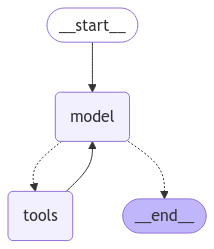

In [58]:
wf2 = StateGraph(MessagesState)

wf2.add_node("model", call_model)
wf2.add_node("tools", ToolNode(tools))

wf2.add_conditional_edges("model", tools_condition)
wf2.add_edge("tools", "model")

wf2.set_entry_point("model")

app2 = wf2.compile()
display(Image(app2.get_graph().draw_mermaid_png()))

In [59]:
app2.invoke({"messages": [("What will be addition of Elon Mask's age and Virat Kohli's age?")]})

/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'messages': [HumanMessage(content="What will be addition of Elon Mask's age and Virat Kohli's age?", additional_kwargs={}, response_metadata={}, id='ba649893-753e-4f44-babe-91cccc45d65d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bmvv', 'function': {'arguments': '{"query":"Elon Musk age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1610, 'total_tokens': 1696, 'completion_time': 0.156363636, 'prompt_time': 0.054881482, 'queue_time': 0.02227139699999999, 'total_time': 0.211245118}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-eb579e56-de00-47ce-b9cd-7e30e2e334f3-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Elon Musk age'}, 'id': 'call_bmvv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1610, 'output_tokens': 86, 'total_tokens': 1696}),
  ToolMessage(content="El

### 3. Langgraph with Human in Loop

In [64]:
def route_call1(state: MessagesState):
    message = state["messages"][-1]
    print(f"\nfrom route {message}\n")
    if message.tool_calls:
        if message.additional_kwargs["tool_calls"][0]["function"]["name"] == 'duckduckgo_search':
            user_permission = input("Do you want to proceed? ")
            if user_permission.lower() == 'y' or user_permission.lower() == 'yes':
                return "tools"
            else:
                raise Exception("Not want to continue")
        return "tools"
    return END



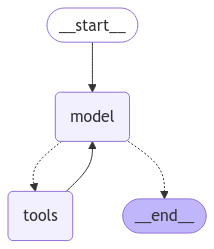

In [65]:
wf3 = StateGraph(MessagesState)

wf3.add_node("model", call_model)
wf3.add_node("tools", ToolNode(tools))

wf3.add_conditional_edges("model", route_call1, {"tools": "tools", END: END})
wf3.add_edge("tools", "model")

wf3.set_entry_point("model")

app3 = wf3.compile()
display(Image(app3.get_graph().draw_mermaid_png()))

In [75]:
app3.invoke({"messages": [("What will be addition of Elon Mask's age and Virat Kohli's age?")]})


from route content='' additional_kwargs={'tool_calls': [{'id': 'call_v8zn', 'function': {'arguments': '{"query":"Elon Musk age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1610, 'total_tokens': 1696, 'completion_time': 0.156363636, 'prompt_time': 0.077685861, 'queue_time': 0.02252074400000001, 'total_time': 0.234049497}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-bb221351-5ce1-4406-9d59-09300df735f6-0' tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Elon Musk age'}, 'id': 'call_v8zn', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1610, 'output_tokens': 86, 'total_tokens': 1696}



/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(



from route content='' additional_kwargs={'tool_calls': [{'id': 'call_yjd5', 'function': {'arguments': '{"query":"Virat Kohli age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 2035, 'total_tokens': 2087, 'completion_time': 0.094545455, 'prompt_time': 0.082985806, 'queue_time': 0.023681168000000002, 'total_time': 0.177531261}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-cdd55eb0-1f57-4f73-b552-14a3e642930f-0' tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Virat Kohli age'}, 'id': 'call_yjd5', 'type': 'tool_call'}] usage_metadata={'input_tokens': 2035, 'output_tokens': 52, 'total_tokens': 2087}



/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(



from route content='' additional_kwargs={'tool_calls': [{'id': 'call_7yn6', 'function': {'arguments': '{"a":35,"b":36}', 'name': 'add'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 2519, 'total_tokens': 2569, 'completion_time': 0.090909091, 'prompt_time': 0.138066805, 'queue_time': 0.022773104000000016, 'total_time': 0.228975896}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-d975a9c2-25bf-4483-be9f-9ca03f7af404-0' tool_calls=[{'name': 'add', 'args': {'a': 35, 'b': 36}, 'id': 'call_7yn6', 'type': 'tool_call'}] usage_metadata={'input_tokens': 2519, 'output_tokens': 50, 'total_tokens': 2569}


from route content="The sum of Elon Musk's age and Virat Kohli's age is 71." additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 2596, 'total_tokens': 2617, 'completion_time': 0.038181818, 'prompt_time': 0.145794412, 'q

{'messages': [HumanMessage(content="What will be addition of Elon Mask's age and Virat Kohli's age?", additional_kwargs={}, response_metadata={}, id='5ba73062-39c4-49fd-be89-99111b22c8a6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v8zn', 'function': {'arguments': '{"query":"Elon Musk age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1610, 'total_tokens': 1696, 'completion_time': 0.156363636, 'prompt_time': 0.077685861, 'queue_time': 0.02252074400000001, 'total_time': 0.234049497}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bb221351-5ce1-4406-9d59-09300df735f6-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Elon Musk age'}, 'id': 'call_v8zn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1610, 'output_tokens': 86, 'total_tokens': 1696}),
  ToolMessage(content='El

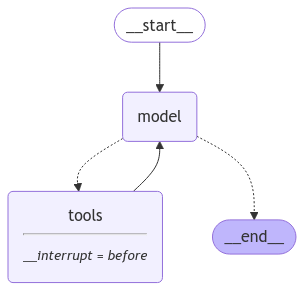

In [99]:
wf4 = StateGraph(MessagesState)

wf4.add_node("model", call_model)
wf4.add_node("tools", ToolNode(tools))

wf4.add_conditional_edges("model", tools_condition)
wf4.add_edge("tools", "model")

wf4.set_entry_point("model")

app4 = wf4.compile(
    interrupt_before=["tools"],
    checkpointer=MemorySaver()
)
config = {"configurable": {"thread_id": "1"}}
display(Image(app4.get_graph().draw_mermaid_png()))



In [100]:
app4.invoke({"messages": [("What will be addition of Elon Mask's age and Virat Kohli's age?")]}, config=config)

{'messages': [HumanMessage(content="What will be addition of Elon Mask's age and Virat Kohli's age?", additional_kwargs={}, response_metadata={}, id='0edecbe7-1853-434e-bf20-1a7266c83611'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vw0f', 'function': {'arguments': '{"query":"Elon Musk\'s age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 1610, 'total_tokens': 1698, 'completion_time': 0.16, 'prompt_time': 0.072403784, 'queue_time': 0.021526045000000008, 'total_time': 0.232403784}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-804bad5b-c958-45f4-9804-a8c8eaead3cd-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': "Elon Musk's age"}, 'id': 'call_vw0f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1610, 'output_tokens': 88, 'total_tokens': 1698})]}

In [101]:
app4.invoke(None, config=config)

/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'messages': [HumanMessage(content="What will be addition of Elon Mask's age and Virat Kohli's age?", additional_kwargs={}, response_metadata={}, id='0edecbe7-1853-434e-bf20-1a7266c83611'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vw0f', 'function': {'arguments': '{"query":"Elon Musk\'s age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 1610, 'total_tokens': 1698, 'completion_time': 0.16, 'prompt_time': 0.072403784, 'queue_time': 0.021526045000000008, 'total_time': 0.232403784}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-804bad5b-c958-45f4-9804-a8c8eaead3cd-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': "Elon Musk's age"}, 'id': 'call_vw0f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1610, 'output_tokens': 88, 'total_tokens': 1698}),
  ToolMessage(content="Elo